Changes to v1:
- change to dots
- linear, quadratic and cubic
- better parameter sampling (valid ranges)
- 500 x 500 pixel

Potential next steps:
- dots sample frequency
- a lot of images are ambiguous, trainings data needs to be cleaned: fit lower level function and check if residual is low -> remap to lower function
- which dot type is the best?
- deployment

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random   
import math
NUM_IMAGES = 1000

# Create data directory if it doesn't exist

x_max = 100
x = np.linspace(-x_max, x_max, 100)



def get_random_linear(x):
    a = math.tan(random.uniform(math.radians(-89.0) , math.radians(89.0)))
    b = random.uniform(-x_max, x_max) 
    x_shift = random.uniform(-x_max, x_max)
    
    print("a:", a, "b:", b)

    return a * (x + x_shift) + b

def get_random_quadratic(x):
    log_a_min = np.log(0.001)  # minimum curvature
    log_a_max = np.log(10.0)    # maximum curvature
    log_a = random.uniform(log_a_min, log_a_max)
    a = np.exp(log_a) * random.choice([-1, 1])  # random sign
    b = math.tan(random.uniform(math.radians(-89.0) , math.radians(89.0)))
    c = random.uniform(-x_max, x_max) 
    x_shift = random.uniform(-x_max, x_max)


    x_shifted = x + x_shift

    return a * x_shifted**2 + b * x_shifted + c

def get_random_cubic(x):
    log_a_min = np.log(0.000001)  # minimum curvature derivative
    log_a_max = np.log(0.1)    # maximum curvature derivative
    log_a = random.uniform(log_a_min, log_a_max)
    a = np.exp(log_a) * random.choice([-1, 1])  # random sign
    b = random.uniform(0.001, 0.1) * random.choice([-1, 1])
    c = math.tan(random.uniform(math.radians(-89.0) , math.radians(89.0)))
    d = random.uniform(-x_max, x_max) 
    x_shift = random.uniform(-x_max, x_max)

    x_shifted = x + x_shift

    return a * x_shifted**3 + b * x_shifted**2 + c * x_shifted + d


def save_plot(x, y, i, label):
    # Create figure with square aspect ratio
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(x, y, 'x', linewidth=4)
    ax.set_xlim([-x_max, x_max])
    ax.set_ylim([-x_max, x_max])

    ax.set_xticks([])
    ax.set_yticks([])



    folder_name = f'data/{label}'

    os.makedirs(folder_name, exist_ok=True)

    file_name = f'{folder_name}/{i}.png'
    plt.savefig(file_name, dpi=50)

    print("label:", label)
    plt.close()  # Close the figure to prevent it from being displayed
    print(f"Plot saved to {file_name}")


for i in range(NUM_IMAGES):
    y_linear = get_random_linear(x)
    save_plot(x, y_linear, i, 'linear')

    y_quadratic = get_random_quadratic(x)
    save_plot(x, y_quadratic, i, 'quadratic')  

    y_cubic = get_random_cubic(x)
    save_plot(x, y_cubic, i, 'cubic')









a: 2.112287865206189 b: -90.27051442823648
label: linear
Plot saved to data/linear/0.png
label: quadratic
Plot saved to data/quadratic/0.png
label: cubic
Plot saved to data/cubic/0.png
a: -4.623471715377745 b: 26.799265953713686
label: linear
Plot saved to data/linear/1.png
label: quadratic
Plot saved to data/quadratic/1.png
label: cubic
Plot saved to data/cubic/1.png
a: -0.8479868193245115 b: -91.17615353555517
label: linear
Plot saved to data/linear/2.png
label: quadratic
Plot saved to data/quadratic/2.png
label: cubic
Plot saved to data/cubic/2.png
a: -3.3742432994906615 b: -76.48368559604123
label: linear
Plot saved to data/linear/3.png
label: quadratic
Plot saved to data/quadratic/3.png
label: cubic
Plot saved to data/cubic/3.png
a: 0.19211650768391114 b: 83.33822022680468
label: linear
Plot saved to data/linear/4.png
label: quadratic
Plot saved to data/quadratic/4.png
label: cubic
Plot saved to data/cubic/4.png
a: 0.4265052443291428 b: 26.188244638409614
label: linear
Plot saved 

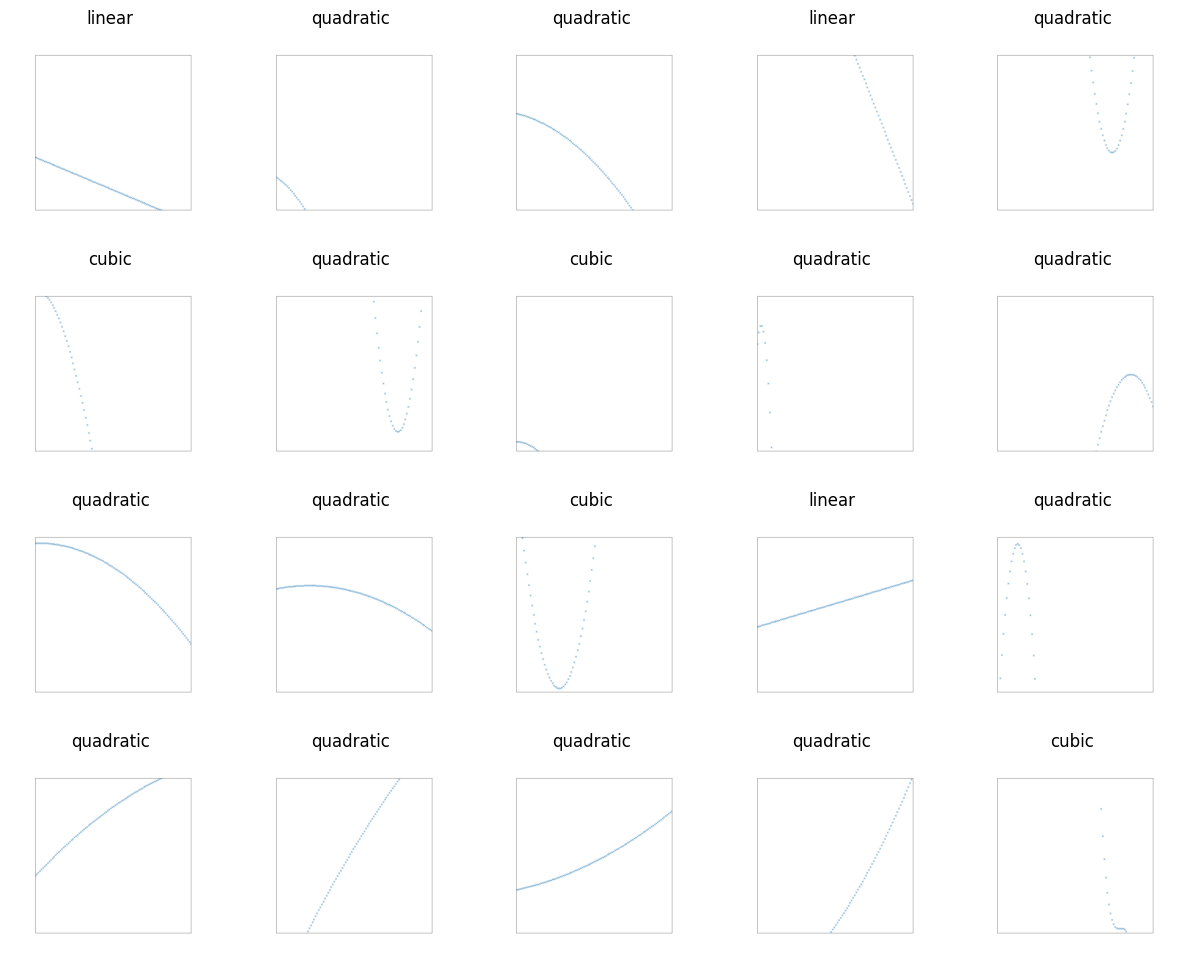

In [ ]:
from fastai.vision.all import *








path = Path('data')

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label
).dataloaders(path, bs=32)

dls.show_batch(max_n=20)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

In [ ]:
learn.export()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
# Function to get all misclassified images
def get_misclassified_images(learn, dls):
    """Get all misclassified images with their predictions and true labels"""
    misclassified = []
    
    # Get validation dataset
    val_dl = dls.valid
    
    # Get predictions for all validation images
    preds, targets = learn.get_preds(dl=val_dl)
    pred_labels = preds.argmax(dim=1)
    
    # Get file paths for validation images
    val_files = val_dl.items
    
    for i, (pred_label, true_label, file_path) in enumerate(zip(pred_labels, targets, val_files)):
        if pred_label != true_label:
            misclassified.append({
                'file_path': file_path,
                'predicted': dls.vocab[pred_label.item()],
                'true': dls.vocab[true_label.item()],
                'confidence': preds[i].max().item()
            })
    
    return misclassified

# Get misclassified images
misclassified_images = get_misclassified_images(learn, dls)
print(f"Found {len(misclassified_images)} misclassified images:")
for img in misclassified_images:
    print(f"File: {img['file_path'].name}, True: {img['true']}, Predicted: {img['predicted']}, Confidence: {img['confidence']:.3f}")


In [ ]:
# Function to plot all misclassified images
def plot_misclassified_images(misclassified_images, max_images=20):
    """Plot all misclassified images in a grid"""
    if not misclassified_images:
        print("No misclassified images found!")
        return
    
    n_images = min(len(misclassified_images), max_images)
    
    # Calculate grid dimensions
    cols = min(4, n_images)
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, img_info in enumerate(misclassified_images[:max_images]):
        # Load and display image
        img = PILImage.create(img_info['file_path'])
        axes[i].imshow(img)
        
        # Set title with prediction info
        title = f"True: {img_info['true']}\nPred: {img_info['predicted']}\nConf: {img_info['confidence']:.3f}"
        axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(n_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Misclassified Images ({len(misclassified_images)} total)", fontsize=16, y=1.02)
    plt.show()

# Plot the misclassified images
plot_misclassified_images(misclassified_images)


In [ ]:
# Detailed analysis of misclassifications
if misclassified_images:
    print("=== MISCLASSIFICATION ANALYSIS ===")
    
    # Count by type
    false_positives = [img for img in misclassified_images if img['true'] == 'x_2' and img['predicted'] == 'x_3']
    false_negatives = [img for img in misclassified_images if img['true'] == 'x_3' and img['predicted'] == 'x_2']
    
    print(f"False Positives (x_2 → x_3): {len(false_positives)}")
    print(f"False Negatives (x_3 → x_2): {len(false_negatives)}")
    
    print("\n=== FALSE POSITIVES (Quadratic misclassified as Cubic) ===")
    for i, img in enumerate(false_positives):
        print(f"{i+1}. {img['file_path'].name} - Confidence: {img['confidence']:.3f}")
    
    print("\n=== FALSE NEGATIVES (Cubic misclassified as Quadratic) ===")
    for i, img in enumerate(false_negatives):
        print(f"{i+1}. {img['file_path'].name} - Confidence: {img['confidence']:.3f}")
    
    # Plot false positives separately if they exist
    if false_positives:
        print(f"\n=== PLOTTING FALSE POSITIVES ===")
        plot_misclassified_images(false_positives, max_images=10)
    
    # Plot false negatives separately if they exist  
    if false_negatives:
        print(f"\n=== PLOTTING FALSE NEGATIVES ===")
        plot_misclassified_images(false_negatives, max_images=10)
else:
    print("No misclassified images found!")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Linear sampling
a_linear = np.linspace(0.001, 0.1, 100)
curvature_linear = 2 * a_linear

# Log sampling  
log_a = np.linspace(np.log(0.001), np.log(0.1), 100)
a_log = np.exp(log_a)
curvature_log = 2 * a_log

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(curvature_linear, bins=20, alpha=0.7, color='blue')
plt.title('Linear Sampling of a')
plt.xlabel('Curvature')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(curvature_log, bins=20, alpha=0.7, color='red')
plt.title('Log-Uniform Sampling of a')
plt.xlabel('Curvature')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()